In [1]:
import pandas as pd
import numpy as np
import networkx as nx

Most of this is adapted directly from FTMSVisualization (https://github.com/wkew/FTMSVisualization) especially 0-FormulaGenerator.py and 1-FormulaAssignment.py files that are the ones relevant to what we want to achieve - make a "database" of possible formulas with their respective exact theoric mass and then assign to a set of m/z peaks a specific formula from said database.

Apart from this, the 2007 paper "Seven Golden Rules for heuristic filtering of molecular formulas obtained by accurate mass spectrometry" of Tobias Kind and Oliver Fiehn was used as a base for the rules used to make the "formula database". This was complemented with some criteria used by Kujawinski et al. (2006) for their CIA software for formula assignment.

### Warning!

This notebook takes a moderate amount of time to run with the current parameters and it asks a bit of RAM memory space. 

Update: Speed of the functions was considerably improved (still takes a good amount of time). RAM and space issues stil exist.


## Part nº 1 - Building the Formula "Database"

### Setting up functions to build the formula database

First a dictionary with all the masses and abundances of different elements (taken from FTMSVisualization).

In [2]:
#Atomic masses - https://ciaaw.org/atomic-masses.htm
#Isotopic abundances - https://ciaaw.org/isotopic-abundances.htm / https://www.degruyter.com/view/journals/pac/88/3/article-p293.xml
#isotoptic abundances from Pure Appl. Chem. 2016; 88(3): 293–306, Isotopic compositions of the elements 2013 (IUPAC Technical Report), doi: 10.1515/pac-2015-0503
#electron mass from NIST http://physics.nist.gov/cgi-bin/cuu/Value?meu|search_for=electron+mass
chemdict = {'H':(1.0078250322, 0.999844),
            'C':(12.000000000, 0.988922),
            'N':(14.003074004, 0.996337),
            'O':(15.994914619, 0.9976206),
            'Na':(22.98976928, 1.0),
            'P':(30.973761998, 1.0),
            'S':(31.972071174, 0.9504074),
            'Cl':(34.9688527, 0.757647),
            'F':(18.998403163, 1.0),
            'C13':(13.003354835, 0.011078)} 

Function to calculate formulas exact masses (Update: Fixed an error - mass of P was counted twice)

In [3]:
def getmass(c,h,o,n,s,p,cl,f):
    "Get the exact mass for any formula."
    massC = chemdict['C'][0] * c
    massH = chemdict['H'][0] * h
    massO = chemdict['O'][0] * o
    massN = chemdict['N'][0] * n
    massS = chemdict['S'][0] * s
    massP = chemdict['P'][0] * p
    massCl = chemdict['Cl'][0] * cl
    massF = chemdict['F'][0] * f 

    massTotal = massC + massH + massO + massN + massS + massP + massCl + massF

    return massTotal

Function to calculate the natural abundances of the formulas made of all the most common isotopes for each element.

In [4]:
def getabun(c,h,o,n,s,cl,c13=False):
    "The natural abundance of the formulas made of all the most common isotopes for each element."
    abunC, abunH, abunO, abunN, abunS, abunCl = 1,1,1,1,1,1
    
    if c13 == False:
        if c > 0:
            abunC = chemdict['C'][1] ** c
    else:
        if c > 0:
            abunC = (chemdict['C'][1] ** (c-1)) * chemdict['C13'][1] * c

    if h > 0:
        abunH = chemdict['H'][1] ** h

    if o > 0:
        abunO = chemdict['O'][1] ** o

    if n > 0:
        abunN = chemdict['N'][1] ** n

    if s > 0:
        abunS = chemdict['S'][1] ** s
        
    if cl > 0:
        abunCl = chemdict['Cl'][1] ** cl

    abunTotal = abunC * abunH * abunO * abunN * abunS * abunCl
    return abunTotal

### Maximum number of elements and ranges for element proportions according to the 7 golden rules paper

In [5]:
#Common range
com_range = {'H/C':(0.2,3.1),'N/C':(0,1.3),'O/C':(0,1.2),'P/C':(0,0.3),'S/C':(0,0.8)} #99.7% of all existing formulas
#Extended range
ext_range = {'H/C':(0.1,6),'N/C':(0,4),'O/C':(0,3),'P/C':(0,2),'S/C':(0,3)} #99.99% of all existing formulas

### Maximum number of elements and ranges for element proportions as per the chemical constraints put upon on the MetaboScape

Issues: Adding Cl and F element leads to exponentially greater amount of formulas and time of analysis.

#### These limits were the ones imposed in the following functions for rule nº1 and rule nº5 of the 7 golden rules.

In [6]:
#Rules applied to the file:
maxC,maxH,maxO,maxN,maxS,maxP = 39,72,20,20,5,9
maxF, maxCl = 8,5
ms_range = {'H/C':(0.2,3.1),'N/C':(0,1.3),'O/C':(0,1.2),'P/C':(0,0.3),'S/C':(0,0.8),'F/C':(0,1.5), 'Cl/C':(0,0.8)}

short_range = {'H/C':(0.4,2.2),'N/C':(0,0.6),'O/C':(0,1.2),'P/C':(0,0.3),'S/C':(0,0.5),'F/C':(0,0.5), 'Cl/C':(0,0.5)}

### Function to give every formula possible and their exact mass between a certain mass interval and according to other limitations such as the 7 golden rules paper or specifically imposed conditions (adapted from FTMSVisualization) - form_calc

Rules nº 1, 2 (partially), 4, 5 and 6 currently followed.

Rule nº 7 - TMS check not applicable.

Rule nº 3 - Isotope pattern checking is very lightly applied on the Formula Assignment step (in two different ways).

#### form_calc function applies all these rules, rules nº2 and 6 however have specific functions.

form_calc includes rule nº 1, 2, 4, 5 and 6 of the 7 Golden Rules and two criteria presented by Kujawinski et al (2006) that made the CIA algorithm (Compound Identification Algorithm) part of the Formularity software used as base to compare the formula assignments between the two.

Kujawinski criteria nº 1 was changed to account for P as they do in the Formularity software (h <= (2c + n + p + 2)) (addition of p).
 
Kujawinski criteria nº 2 was lightened since Formularity software broke this rule many times ((n + o) <= 2c) (instead of c).

In [7]:
def form_calc(low, high, elem_range = com_range):
    """Calculates all formulas possible (according to some stipulations) between a certain mass interval.
    
       low: scalar; lower limit of the molecular mass of the formula.
       high: scalar, upper limit of the molecular mass of the formula.
       elem_range: dictionary; dictionary where keys are string of the ratios of certain elements (examples: 'H/C', 'O/C') and
    their values are a tuple with the minimum and maximum ratios they can have in a certain formula (rule nº5).
    
       return: dictionary where keys are exact masses and values are tuples with the overall abundance of the monoisotopic 
    'mass', the number of atoms of each elements (in a specific order), bool value to if the formula follows the valency rules 
    when its elements are in their most common valency, the abundance and mass of the isotope with 1 C(13) atom and a defaulted
    False that is meant to see if the C(13) isotope mass or the monoisotopic mass is being used.
    """
    
    """Following the maximum elements from the recommended in 7 Golden Rules paper."""
    #RULE Nº 1 - Following the 7 golden rule limits
    if high <= 500:
        maxC,maxH,maxO,maxN,maxS,maxP = 39,72,20,20,10,9
    elif high <= 1000: #36 7 golden rules?
        maxC,maxH,maxO,maxN,maxS,maxP = 78,126,27,25,14,9
    #else: #elif m < 2000:
        #maxC,maxH,maxO,maxN,maxS,maxP = 156,180,63,32,14,9

    """Following the maximum elements from the limits imposed to MetaboScape."""
   # maxC,maxH,maxO,maxN,maxS,maxP = 39,72,20,20,5,9
    maxF, maxCl = 0,0
    
    maxC = min((int(high) / 12), maxC + 1) #max carbon nº is the smaller of the total mass/12 or predefined maxC
    maxH2 = min((maxC * 4), maxH + 1) #max hydrogen nº is the smaller of 4 times the nº of carbons or the predefined max hydrogen nº
    maxO2 = min((int(high) / 16), maxO + 1)#max oxygen nº has to be the smaller of the total mass/16 or predefined maxO
    #Maybe those 3 above on the int part should have a +1 next to them.
    maxN2 = maxN + 1
    maxS2 = maxS + 1
    maxP2 = maxP + 1
    maxF2 = maxF + 1
    maxCl2 = maxCl + 1

    allposs = {} #pd.DataFrame(columns = ['abundance', 'c','h','o','n','s','p'])

    for c in range(int(maxC))[1:]: #molecules contain at least 1 C and 1 H
        #mass = 0
        #print(int(elem_range['H/C'][1]*c), elem_range['H/C'][1]*c)
        maxCl = min(maxCl2, int(c * elem_range['Cl/C'][1]+0.99)) #RULE Nº 5
        for cl in range(maxCl):
            massCl = chemdict['C'][0] * c + chemdict['Cl'][0] * cl
            if massCl < high:
                maxS = min(maxS2, int(c * elem_range['S/C'][1]+0.99)) #RULE Nº 5
                for s in range(maxS):
                    massS = massCl + chemdict['S'][0] * s
                    if massS < high:
                        maxP = min(maxP2, int(c * elem_range['P/C'][1]+0.99)) #RULE Nº 5
                        for p in range(maxP):
                            massP = massS + chemdict['P'][0] * p
                            if massP < high:
                                maxO = min(maxO2, int(c * elem_range['O/C'][1]+0.99)) #RULE Nº 5
                                for o in range(int(maxO)):
                                    massO = massP + chemdict['O'][0] * o
                                    if massO < high:
                                        maxN = min(maxN2, int(c * elem_range['N/C'][1]+0.99)) #RULE Nº 5
                                        for n in range(maxN):
                                            massN = massO + chemdict['N'][0] * n
                                            if massN < high:
                                                #print(n)
                                                if (n + o) <= 2*c:
                                                    NOPS_ratio = NOPS(n,o,p,s)
                                                    if NOPS_ratio: #RULE Nº 6 - element probability check - see function below
                                                        maxF = min(maxF2, int(c * elem_range['F/C'][1]+0.99)) #RULE Nº 5
                                                        for f in range(maxF):
                                                            massF = massN + chemdict['F'][0] * f 
                                                            if massF < high:
                                                                maxH = min(elem_range['H/C'][1] * c + 0.99, maxH2)
                                                                for h in range(int(maxH))[1:]:
                                                                    hcrat = float(h)/float(c)
                                                                    if elem_range['H/C'][0] < hcrat: # < elem_range['H/C'][1]: #RULE Nº 4
                                                                        mass = massF + chemdict['H'][0] * h
                                                                        if h <= (2*c + n + p + 2):
                                                                            if low < mass < high:
                                                                                Valency, Valency_normal = Lewis_Senior_rules(c,h,o,n,s,p,cl,f)
                                                                                if Valency:
                                                                                    abundance = getabun(c,h,o,n,s,cl)
                                                                                    abundanceC13 = getabun(c,h,o,n,s,cl,c13=True)
                                                                                    massC13 = mass + chemdict['C13'][0] - chemdict['C'][0]
                                                                                    allposs[mass] = (abundance,c,h,o,n,s,p,cl,f,Valency_normal,abundanceC13,massC13,False)

    return allposs

### Rule nº 6 - HNOPS heuristic probability check

FTMSVisualization didn't impose this rule. Instead, they did something else where they said that the total number of heteroatoms had to be smaller than 1.3 times the number of carbons. I altered to this to follow the 7 golden rules paper more closely. The following function sees if there are at least 3 types of heteroatoms in the formula and then observes if each of their counts is below a threshold shown in the 7 golden rules paper. If it isn't, NOPS_ratio is False and the formula is ignored.

#### Possible problem:

No extra heteroatom checks for F and Cl elements. This means that they are basically treated as non-heteroatoms so far. There should probably be soem kind of check that takes into account their presence when other heteroatoms are also present but I haven't found something like that in the literature yet.

In [8]:
#Rule nº 6 - HNOPS heuristic probability check
def NOPS (n,o,p,s):
    """Checks if the element counts follow the HNOPS heuristic probablility checks as delineated by the 7 golden rules paper.
    
       n,o,p,s - integers; number of N, O, P and S atoms respectively in the considered formula.
       
       returns: bool; True if it fulfills the conditions, False if it doesn't."""
    
    NOPS_ratio = True
    if (n > 1) and (o > 1) and (p > 1) and (s > 1): #NOPS
        if (n < 10) and (o < 20) and (p < 4) and (s < 3):
            NOPS_ratio = True
        else:
            NOPS_ratio = False
    elif (n > 3) and (o > 3) and (p > 3): #NOP
        if (n < 11) and (o < 22) and (p < 6):
            NOPS_ratio = True
        else:
            NOPS_ratio = False
    elif (o > 1) and (p > 1) and (s > 1): #OPS
        if (o < 14) and (p < 3) and (s < 3):
            NOPS_ratio = True
        else:
            NOPS_ratio = False
    elif (n > 1) and (p > 1) and (s > 1): #PSN
        if (n < 10) and (p < 4) and (s < 3):
            NOPS_ratio = True
        else:
            NOPS_ratio = False
    elif (n > 6) and (o > 6) and (s > 6): #PSN
        if (n < 19) and (o < 14) and (s < 8):
            NOPS_ratio = True
        else:
            NOPS_ratio = False

    return NOPS_ratio

### Rule nº 2 - Lewis and Senior (chemical rules) check

FTMSVisualization didn't impose this rule strictly . Instead, they checked the sum of the H and N (Na and K too, ionic compositions) elements to see if the formula followed a strict N rule, see if the sum was odd (not allowed) or even (allowed).

I altered this to follow the 7 golden rules paper more closely which says the following:

i) The sum of valences or the total number of atoms having odd valences is even;  - (close to the N rule followed)

ii) The sum of valences is greater than or equal to twice the maximum valence;

iii) The sum of valences is greater than or equal to twice the number of atoms minus 1 - (see if we can actually make a structure with those molecules - exaggerated since we are considering all molecules can always have their maximum valence state.


While "allowing maximum valence states for each element" i.e. allowing for elements to be in higher valences that they can assume in some molecules and not only their ground states (example: N usually has a valence of 3 establishing 3 bonds, but can have a valence of 4 (molecules with NO2 groups) or 5). Maximum valences for each element is an absolute value.

Rule ii) As I've seen in a paper ('ANALOGOUS ODD-EVEN PARITIES IN MATHEMATICS AND CHEMISTRY', 2003, Morikawa T and Newbold BT), the objective of this rule is to indicate "the non-existence of small molecules such as CH2" (although they don't expalin what maximum valence is). Since we are dealing with molecules with, at least, 100 Da, I ignored this rule so far.

The function so makes a minimum requirement for the formula to fulfill all these rules with their elements in the maximum valency and gives an indication if the formula also follows these rules with their elements in their most common valency.

In [9]:
def Lewis_Senior_rules(c,h,o=0,n=0,s=0,p=0,cl=0,f=0):
    """See if the formula follows Lewis' and Senior's rules (considering all max possible valency states for each element
    except Cl).
    
       c,h,o,n,s,p,cl,f - integers; number of C, H, O, N, S, P, Cl and F atoms respectively in the considered formula.
       
       returns: (bool, bool); (considering max valency in each element, considering normal valency of each element), True if
    it fulfills the conditions, False if it doesn't."""
    
    #Max_Valencies
    valC = 4
    valH = 1 #ODD
    valO = 2 #Positive instead of negative for it to work?
    valN, max_valN = 3, 5 #Normally 3, ODD
    valS, max_valS = 2, 6 
    valP, max_valP = 3, 5 #Normally -3, Odd
    valCl, max_valCl = 1, 7 #7 #Normally -1, Odd ????
    valF = 1 #Normally -1, Odd
    
    Valency = False
    Valency_normal = False
    #1st rule - The sum of valences or the total number of atoms having odd valences is even.
    if (h + n + p + cl + f) % 2 == 0:
        #Elements with their max valences
        total_max_v = (valC * c) + (valH * h) + (valO * o) + (max_valN * n) + (max_valS * s) + (max_valP * p) + (max_valCl * cl) + (valF * f)
            #2nd rule - The sum of valences is greater than or equal to twice the maximum valence.
            #Ok, not applying this one since it normally only eliminates small molecules either way and we are searching for molecules
            #with more than 100 Da.

            #3rd rule - The sum of valences is greater than or equal to twice the number of atoms minus 1.
        natoms = c + h + o + n + s + p + cl + f
        if total_max_v >= (2*(natoms-1)):
            Valency = True
        
        if Valency:
            #Elements with their common valences
            total_v = (valC * c) + (valH * h) + (valO * o) + (valN * n) + (valS * s) + (valP * p) + (valCl * cl) + (valF * f)
            #3rd rule - The sum of valences is greater than or equal to twice the number of atoms minus 1.
            #natoms = c + h + o + n + s + p + cl + f
            if total_v >= (2*(natoms-1)):
                Valency_normal = True

    return Valency, Valency_normal

Making a dictionary of dataframes with each dataframe having all possible formulas (according to the previously mentioned rules and functions) of a 100 mass interval with the name of each dataframe being dict + lower (normal) limit of said mass interval.

#### Warning: Don't do range (1,12) here

In [10]:
formulas = {}
dif = chemdict['C13'][0] - chemdict['C'][0]
#Change range here - don't do range(1,12)!!
#Example range(1,4), gives in the formula dictionary 3 DataFrames with formulas with m/z between 100-200, 200-300 and 300-400
for i in range(1,8):
    #i*100 - dif - 0.001 = the idea here is to account for possible C(13) isotopes that might surpass the i*100 barrier while
    #the monoisotopic formula wouldn't which would lead to an error in the formula assignment procedure if the monoisotopic
    #isn't present in the database. That does mean there is a slight overlap between the different files.
    a = form_calc(i*100 - dif - 0.001, (i+1)*100 + dif + 0.001, elem_range = ms_range)
    formulas['dict' + str(i*100)] = pd.DataFrame.from_dict(a, orient = 'index', columns = ['Abundance', 'C','H','O','N','S','P',
                                                                                           'Cl','F','Valency','C13 Abun','C13 mass','C13 check'])
    formulas['dict' + str(i*100)] = formulas['dict' + str(i*100)].sort_index()
    print(i*100, 'complete')
    #Writing a .csv file of the data
    #formulas['dict' + str(i*100)].to_csv('dict' + str(i*100) + '.csv')


100 complete
200 complete
300 complete
400 complete
500 complete
600 complete
700 complete


Writing individual files if one wants to. 

In [11]:
formulas

{'dict100':             Abundance   C  H  O  N  S  P  Cl  F  Valency  C13 Abun  \
 99.014270    0.904952   4  5  0  1  1  0   0  0     True  0.040549   
 99.023786    0.952024   4  6  0  1  0  1   0  0     True  0.042659   
 99.032028    0.947647   4  5  2  1  0  0   0  0     True  0.042463   
 99.043262    0.953524   3  5  1  3  0  0   0  0     True  0.032044   
 99.068414    0.938798   5  9  1  1  0  0   0  0     True  0.052583   
 ...               ...  .. .. .. .. .. ..  .. ..      ...       ...   
 200.995660   0.885691   4  3  3  5  1  0   0  0     True  0.039686   
 200.997965   0.886516  10  4  2  1  0  1   0  0     True  0.099308   
 200.999683   0.847909   9  3  1  3  1  0   0  0     True  0.085485   
 201.001337   0.870641   7  8  2  1  1  1   0  0     True  0.068271   
 201.003054   0.832725   6  7  1  3  2  0   0  0     True  0.055970   
 
               C13 mass  C13 check  
 99.014270   100.017625      False  
 99.023786   100.027141      False  
 99.032028   100.035383 

## Part nº2 - Assigning Formulas to m/z peaks / bucket labels

Reading result files from Formularity. Two main datasets were used:

1) the test set that comes with formularity (test_peaks)

2) the first replicate of the CAN grapevine variety spectrum obtained in Negative mode.

In [12]:
#Original file in the example_results of Formularity as an example
#formula_file = pd.read_csv('report.csv')

electron_mass = 0.0005485799#09065

#formula_file[formula_file['El_comp'].notnull()]

In [13]:
#Test peak files with parameters: S+P Formula score, 0,5 ppm, 700 limit database
Test_SP_05 = pd.read_csv('Formularity_data/testpeaks_report.csv')
#Test_SP_05[Test_SP_05['El_comp'].notnull()]

#Test peak files with parameters: N+S+P Formula score, 1 ppm, 800 limit database
Test_NSP_10 = pd.read_csv('Formularity_data/TESTP_NSP_1_800.csv')
#Test_NSP_10[Test_NSP_10['El_comp'].notnull()]

#CAN file with parameters: S+P Formula score, 1 ppm, 800 limit database
SP_10 = pd.read_csv('Formularity_data/CAN_SP_1_800.csv')
#SP_10[SP_10['El_comp'].notnull()]

#CAN file with parameters: S+P Formula score, 0,5 ppm, 800 limit database
SP_05 = pd.read_csv('Formularity_data/CAN_SP_05.csv')
#SP_05[SP_05['El_comp'].notnull()]

#CAN file with parameters: N+S+P Formula score, 0,5 ppm, 800 limit database
NSP_05 = pd.read_csv('Formularity_data/CAN_NSP_0.5_800.csv')
#NSP_05[NSP_05['El_comp'].notnull()]

#CAN file with parameters: N+S+P Formula score, 1 ppm, 800 limit database
NSP_10 = pd.read_csv('Formularity_data/CAN_NSP_1_800.csv')
NSP_10[NSP_10['El_comp'].notnull()]

,Mass,C,H,O,N,C13,S,P,Na,El_comp,Class,NeutralMass,Error_ppm,Candidates,CAN1 (1)
48,171.10276,9,16,3,0,0,0,0,0,CHO,Protein,172.110036,-0.535047,1,542141
61,185.09613,7,15,0,4,0,0,1,0,CHNP,Lipid,186.103406,0.142638,1,2759693
63,187.09777,9,16,4,0,0,0,0,0,CHO,Protein,188.105046,-0.996597,1,883076
68,238.03067,7,14,4,1,0,1,1,0,CHONSP,AminoSugar,239.037946,0.705646,2,1601493
73,239.03565,7,8,2,6,0,1,0,0,CHONS,Lignin,240.042926,0.073967,1,559354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,747.49423,57,64,0,0,0,0,0,0,CH,UnsatHC,748.501506,-0.941097,15,882589
563,755.28188,41,44,12,2,0,0,0,0,CHON,Lignin,756.289156,0.354919,38,708393
564,761.44441,37,66,14,2,0,0,0,0,CHON,Protein,762.451686,-0.369372,18,807533
565,771.25104,38,44,17,0,0,0,0,0,CHO,Lignin,772.258316,-0.604045,50,1014089


### Function to assign a formula - form_checker 

#### 2 different form_checker - first is the oldest one that only searches for C13 isotope peaks of already assigned formulas and the second one (newest) includes the presence of possible C13 peaks as a criterium for the attribution of the "monoisotopic" peak.

### form_checker 1 - around 14:15 min for ~7000 peaks with the current formula database

How the function works:

1) Select formulas that are within the threshold (in ppm - thresppm) chosen.

2) See if there is a possibility that the peak might be an isotope of a previously assigned formula.

3) If no, go to step 7)

4) If yes and the intensity of the peak is very close to the expected based on the relative natural abundancies from the isotopes between the monoisotopic peak and the C(13) peak, the formula is right away assigned to the peak.

5) If yes and the intensity of the peak is somewhat close to the expected based on the relative natural abundancies from the isotopes between the monoisotopic peak and the C(13) peak, the formula is added to the list of possible formulas got in 1) to pass the different formula criteria in step 7).

6) If yes but the intensity of the peak is very far from the expected, the formula isn't added to the list of possible formulas got in 1).

7) Different criteria for formula assignment are made and the best candidate from the list of possible formulas is assigned to the peak. The criteria and checks used are the following (in order):

All criteria used are skipped if no formula present in the candidates passes a specific criterion. If only one formula passes a specific criterion, that formula is assigned and all further criteria are skipped.

- Check nº 1: Just a check for if there are multiple candidates, if there is only one candidate, that formula is assigned, if there isn't any, no formula is assigned.

- Check nº 2: Check if the candidate formulas follow valency rules with their elements in their most common valency.

- Check nº 3 (Removed): Candidate formulas with less number of different heteroatoms are prioritized - first formulas with only C, H, O and N and then formulas with only C, H, O, N, S and P. This check was taken out since it worsens comparisons.

- Check nº 4: Prioritize formulas with lowest absolute number of heteroatoms - counting N, S, P (Cl and F) to mimick Formularity.

- Check nº 5: Choose from the remaining formulas, the one with the lowest absolute error between theoretical and experimental mass.

In [14]:
def form_checker(mass, threshppm, df, intensity, assignments, isotope_check=True):
    """Assigning formulas to an m/z peak based on the distance of the m/z to the formulas present in a given database.
    
       mass: scalar; m/z of the peak.
       threshppm: scalar; error threshold for formulae in ppm - i.e. relative error threshold.
       df: Pandas Dataframe; dataframe with the formulas that are possible to assign to the m/z peak.
       intensity: scalar; intensity of the peak.
       assignments: Pandas Dataframe; previous formula assignments made in the dataset.
       isotope_check: bool (default: True); 
       
       returns: tuple with the mass given, the formula assigned (np.nan if no formula could be assigned within the 2 given
    thresholds) and the intensity of the peak."""
    
    #Calculate mass difference allowed based on the mass and ppm thresholds given
    mass_dif = mass - (mass*1000000/(1000000 + threshppm))
    #Select the formulas from the database dataframe that are within said mass difference to the mass given
    df2 = df.copy()
    df2 = df2[df2.index<= (mass+mass_dif)]
    df2 = df2[df2.index>= (mass-mass_dif)]
    #print('df2', df2)
    
    #Isotope Checker
    if isotope_check == True:
        #See if there are previously assigned formulas that could have a C(13) isotope around the mass 
        
        #This is actually the mass of a monoisotopic peak
        monoiso_mass = mass - chemdict['C13'][0] + chemdict['C'][0]
        monoiso_mass_dif = monoiso_mass - (monoiso_mass*1000000/(1000000 + threshppm)) #Some doubts here
        #isos renamed to iso_candidates and close_iso renamed to close_iso_candidates for more clarity
        #Possible previously assigned formulas that are candidate to have the C(13) isotope around the mass
        iso_candidates = forma[forma.index <= (monoiso_mass + mass_dif + monoiso_mass_dif)]
        iso_candidates = iso_candidates[iso_candidates.index >= (monoiso_mass - mass_dif - monoiso_mass_dif)] 
        #Only consider peaks that had formulas assigned previously
        iso_candidates = iso_candidates[iso_candidates['Form_give'].notnull()]
        #print('iso_candidates', iso_candidates)
        
        if len(iso_candidates) != 0: #If there were possible candidates
            #Not consider previously assigned peaks that already were C(13) isotopes of other peaks
            iso_candidates = iso_candidates[~iso_candidates['Form_give'].str.endswith('C(13)')]
            #iso_candidates = iso_candidates[iso_candidates['Form_give'].str.endswith('C(13)')]
            #print(isos, intensity)
            close_iso_candidates = pd.DataFrame(columns = df2.columns)
            
            for i in range(len(iso_candidates)):
                #theo_relative_intensity = the theoretical relative intensity between C(13) isotope and monoisotopic peaks 
                #according to natural abundancy.
                theo_relative_intensity = df.loc[iso_candidates['Theo_mass'].iloc[i]].iloc[-3] / df.loc[
                    iso_candidates['Theo_mass'].iloc[i]].iloc[0]
                #exp_relative_intensity = the experimental relative intensity between the two peaks
                exp_relative_intensity = intensity / iso_candidates['Intensity'].iloc[i]
                #print(exp_relative_intensity, theo_relative_intensity)
                
                #See if the experimental relative intensity is close to the theoretical.
                if (exp_relative_intensity > (theo_relative_intensity - 0.6*theo_relative_intensity) 
                    and exp_relative_intensity < (theo_relative_intensity + 0.6)):
                    #print(df.loc[isos['Theo_mass'].iloc[i]])
                    
                    #Add to the candidate formulas the C(13) isotope information by modifying the monoisotopic mass information
                    df2.loc[df.loc[iso_candidates['Theo_mass'].iloc[i]].iloc[-2]] = df.loc[iso_candidates['Theo_mass'].iloc[i]]
                    df2.loc[df.loc[iso_candidates['Theo_mass'].iloc[i]].iloc[-2],'C13 check'] = 1
                    df2.loc[df.loc[iso_candidates['Theo_mass'].iloc[i]].iloc[-2],'C'] = df.loc[
                        iso_candidates['Theo_mass'].iloc[i]].loc['C'] - 1
                    
                    #See if the experimental relative intensity is very close to the theoretical.
                    if (exp_relative_intensity > (theo_relative_intensity - 0.2*theo_relative_intensity) and 
                        exp_relative_intensity < (theo_relative_intensity + 0.2*theo_relative_intensity)):
                        close_iso_candidates.loc[df.loc[iso_candidates['Theo_mass'].iloc[i]].iloc[-2]] = df2.loc[df.loc[iso_candidates['Theo_mass'].iloc[i]].iloc[-2]]
                        #print(close_isos)
            
            #If there are very close isotopes candidates, the formulas assigned will be one of them
            if len(close_iso_candidates) != 0:
                if len(close_iso_candidates) == 1:
                    df2 = close_iso_candidates
                    return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                            df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                            df2['C13 check'].values[0]),
                          df2.index[0])#,
                else:
                    df2 = close_iso_candidates
    
    #Criteria for more than one possiblity: Check number of possible formulas, normal_valency allows formula, check formulas
    #with low amounts of different heteroatoms, check formulas with lowest amounts of heteroatoms, make smallest error check.
    
    #Check nº 1: If more than one formula exists:
    if len(df2) > 1:
        #Check nº 2: if there are formulas that can exist with elements in their most common valency
        #Con: Formulas with groups NO2 where N has a valency of 4 will be excluded
        df_valency = df2[df2['Valency'] == True]
        #print('CHECK Nº1', df_valency)
        if len(df_valency) != 0:
            df2 = df_valency
            if len(df2) == 1:
                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                        df2['C13 check'].values[0]),
                      df2.index[0])#,
                                        #df2['C13'].values[0]))

#        #Check if the formulas follows the stricter Kujawinski criterion - doesn't help  
#        df_no = df2[(df2['N'] + df2['O']) <= df2['C']]
#        if len(df_no) != 0:
#            df2 = df_no
#            if len(df2) == 1:
#                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
#                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
#                                        df2['C13 check'].values[0]),
#                      df2.index[0])#,
        
#        #Check nº 3: if there are formulas with low amounts of different heteroatoms: first prioritize C,H,O,N. - doesn't help
#        #df_CHON = df2[df2['S'] + df2['P'] + df2['F'] + df2['Cl'] == 0]
#        df_CHON = df2[df2['S'] + df2['P'] + df2['F'] + df2['Cl'] + df2['N'] == 0]
#        if len(df_CHON) != 0:
#            #df2 = df_CHON
#            if len(df2) == 1:
#                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
#                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
#                                        df2['C13 check'].values[0]),
#                      df2.index[0])#,
                                        #df2['C13'].values[0]))
            
#        #Check nº 3 part 2: if there are formulas with low amounts of different heteroatoms: prioritize C,H,O,N,S,P.
#        #Not applicable
#        df_CHONSP = df2[df2['F'] + df2['Cl'] == 0]
#        df4 = df4[df4['Cl'] == 0]
#        if len(df_CHONSP) != 0:
#            df2 = df_CHONSP
#            if len(df2) == 1:
#                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
#                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0]))
        
        if len(df2) > 1:
            #Check nº 4: Lowest Heteroatom count
            df2 = df2[df2[['N','S','P','F','Cl']].sum(axis = 1) == 
                      df2[['N','S','P','F','Cl']].sum(axis = 1).min()]
            #df2 = df2[df2[['S','P']].sum(axis = 1) == 
            #          df2[['S','P']].sum(axis = 1).min()]
            #print('CHECK Nº2', df2)
            if len(df2) == 1:
                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                        df2['C13 check'].values[0]),
                      df2.index[0])#,
                                        #df2['C13 check'].values[0]))
            
            #Final Check: Lowest error
            #Calculate and store the error (in ppm) of the mass of the filtered formulas
            df3 = pd.DataFrame(abs(((mass - df2.index)/df2.index)*1000000), index = df2.index, columns = ['error'])
            mini = df3.idxmin(axis = 'index')
            #Choose the formula with the lowest error (closest to original mass).
            return(mass, formulator(df2.loc[mini, 'C'].values[0],df2.loc[mini,'H'].values[0],df2.loc[mini,'O'].values[0],
                                    df2.loc[mini,'N'].values[0],df2.loc[mini,'S'].values[0],df2.loc[mini,'P'].values[0],
                                    df2.loc[mini,'F'].values[0], df2.loc[mini,'Cl'].values[0],
                                    df2.loc[mini,'C13 check'].values[0]),
                   mini[0])
    
    #Only one formula is within the mass interval - it will be assigned
    elif len(df2) == 1:
        return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],df2['S'].values[0],
                                df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0], df2['C13 check'].values[0]),
              df2.index[0])
    
    #No formula is within the mass interval - no formula assigned
    else: 
        return(mass, np.nan, np.nan)

### form_checker 2 - around 13:40 min for ~7000 peaks with the current formula database

How the function works:

1) Select formulas that are within the threshold (in ppm - thresppm) chosen.

2) See if the current mass analyzed was chosen before as the C(13) peak of a previously assigned formula. If yes, assign said formula to the peak.

3) See if there are possible C(13) peaks for each of the possible formulas based on the expected m/z for the isotope and the relative natural abundancies of the monoisotopic peaks and the C(13) peak for each formula (less than 80% variation in relation to the observed relation) that the peak might be an isotope of a previously assigned formula.

4) Different criteria for formula assignment are made and the best candidate from the list of possible formulas is assigned to the peak. The criteria and checks used are the following (in order):

All criteria used are skipped if no formula present in the candidates passes a specific criterion. If only one formula passes a specific criterion, that formula is assigned and all further criteria are skipped.

- Check nº 1: Check which of the candidate formulas have possible and viable C(13) peaks in the mass list.

- Check nº 2: Just a check for if there are multiple candidates, if there is only one candidate, that formula is assigned, if there isn't any, no formula is assigned.

- Check nº 3: Check if the candidate formulas follow valency rules with their elements in their most common valency.

- Check nº 4: Prioritize formulas with lowest absolute number of heteroatoms - counting N, S, P (Cl and F) to mimick Formularity.

- Check nº 5: Choose from the remaining formulas, the one with the lowest absolute error between theoretical and experimental mass.

5) For the formula chosen, select, if existant, the best peak candidate to be its C(13) isotope based on first its relative intensity and then it's m/z. If a peak is selected the formula will be assigned at point 2) when that peak is analysed.

In [15]:
def form_checker(mass, threshppm, df, intensity, mass_list, dict_iso={}, isotope_check=True):
    """Assigning formulas to an m/z peak based on the distance of the m/z to the formulas present in a given database.
    
       mass: scalar; m/z of the peak.
       threshppm: scalar; error threshold for formulae in ppm - i.e. relative error threshold.
       df: Pandas Dataframe; dataframe with the formulas that are possible to assign to the m/z peak.
       intensity: scalar; intensity of the peak.
       mass_list: Pandas Dataframe; list of masses that will have formulas assigned.
       dict_iso: dictionary; dictionary with information about which masses will be considered C(13) peaks and with which formula
       isotope_check: bool (default: True); 
       
       returns: tuple with the mass given, the formula assigned (np.nan if no formula could be assigned within the 2 given
    thresholds) and the intensity of the peak."""
    
    #Calculate mass difference allowed based on the mass and ppm thresholds given
    mass_dif = mass - (mass*1000000/(1000000 + threshppm))
    #Select the formulas from the database dataframe that are within said mass difference to the mass given
    df2 = df.copy()
    df2 = df2[df2.index<= (mass+mass_dif)]
    df2 = df2[df2.index>= (mass-mass_dif)]
    #print('df2', df2)
    #print(mass)
    #Isotope Checker
    if isotope_check == True:
        #print('mass in dict_iso:', mass in dict_iso.keys())
        if mass in dict_iso.keys():
            #print('df2', dict_iso[mass])
            if len(dict_iso[mass]) != 0:
                df2 = dict_iso[mass]
                return(mass,
                       formulator(df2['C'].values[0] - 1,df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                 df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                 True),
                       df2['C13 mass'].values[0],
                       dict_iso)
        #print(mass)
        c13iso_mass = mass - chemdict['C'][0] + chemdict['C13'][0]
        c13iso_mass_dif = c13iso_mass - (c13iso_mass*1000000/(1000000 + threshppm)) #Some doubts here
        #print(mass, c13iso_mass)
        
        iso_candidates = mass_list[mass_list.iloc[:,0] <= (c13iso_mass + mass_dif + c13iso_mass_dif)]
        iso_candidates = iso_candidates[iso_candidates.iloc[:,0] >= (c13iso_mass - mass_dif - c13iso_mass_dif)] 
        #print(iso_candidates)
        
        if len(iso_candidates) != 0:
            close_iso_candidates = pd.DataFrame(columns = df2.columns)
                #theo_relative_intensity = the theoretical relative intensity between C(13) isotope and monoisotopic peaks 
                #according to natural abundancy.
                #exp_relative_intensity = the experimental relative intensity between the two peaks
            exp_relative_intensity = iso_candidates.iloc[:, -1] / intensity
            iso_candidates['exp_rel_int'] = iso_candidates.iloc[:, -1] / intensity
            #print(len(iso_candidates))
            
        #print('iso_candidates')
        
    
    #Criteria for more than one possiblity: Check number of possible formulas, normal_valency allows formula, check formulas
    #with low amounts of different heteroatoms, check formulas with lowest amounts of heteroatoms, make smallest error check.
    #print(df2)
    dict_iso_candidates = {'all': ()}
    #Check Extra: if the possible isotope candidates follow the approximmate intensity ratio expected
    if isotope_check == True:
        if len(iso_candidates) != 0:
            theo_relative_intensity = df2['C13 Abun']/df2['Abundance']
            for i in range(len(iso_candidates)):
                #print(df2)
                #print(theo_relative_intensity)
                df_iso = df2[theo_relative_intensity - theo_relative_intensity*0.8 < iso_candidates['exp_rel_int'].iloc[i]]
                df_iso = df_iso[df_iso['C13 Abun']/df_iso['Abundance'] + df_iso['C13 Abun']/df_iso['Abundance']*0.8 > 
                                iso_candidates['exp_rel_int'].iloc[i]]
                dict_iso[iso_candidates['NeutralMass'].iloc[i]] = df_iso
                dict_iso_candidates['all'] = dict_iso_candidates['all'] + tuple(df_iso.index)
                #dict_iso[iso_candidates['NeutralMass'].iloc[i]] = df_iso
                #print(dict_iso, dict_iso_candidates)
                
            if len(dict_iso_candidates['all']) != 0:
                df2 = df2[df2.index.isin(dict_iso_candidates['all'])]
    
    #print('aqui')
    #Check nº 1: If more than one formula exists:
    if len(df2) > 1:
        #Check nº 2: if there are formulas that can exist with elements in their most common valency
        #Con: Formulas with groups NO2 where N has a valency of 4 will be excluded
        df_valency = df2[df2['Valency'] == True]
        if len(df_valency) != 0:
            df2 = df_valency
            if len(df2) == 1:
                if isotope_check == True:
                    if len(iso_candidates) != 0:
                        dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                        df2['C13 check'].values[0]),
                      df2.index[0],
                      dict_iso)#,
                                        #df2['C13'].values[0]))


                
                
        
        if len(df2) > 1:
            #Check nº 4: Lowest Heteroatom count
            df2 = df2[df2[['N','S','P','F','Cl']].sum(axis = 1) == 
                      df2[['N','S','P','F','Cl']].sum(axis = 1).min()]
            #df2 = df2[df2[['S','P']].sum(axis = 1) == 
            #          df2[['S','P']].sum(axis = 1).min()]
            if len(df2) == 1:
                if isotope_check == True:
                    if len(iso_candidates) != 0:
                        dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
                
                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                        df2['C13 check'].values[0]),
                      df2.index[0],
                      dict_iso)#,
                                        #df2['C13 check'].values[0]))
            
            #Final Check: Lowest error
            #Calculate and store the error (in ppm) of the mass of the filtered formulas
            df3 = pd.DataFrame(abs(((mass - df2.index)/df2.index)*1000000), index = df2.index, columns = ['error'])
            mini = df3.idxmin(axis = 'index')
            #Choose the formula with the lowest error (closest to original mass).
            if isotope_check == True:
                    if len(iso_candidates) != 0:
                        dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
            return(mass, formulator(df2.loc[mini, 'C'].values[0],df2.loc[mini,'H'].values[0],df2.loc[mini,'O'].values[0],
                                    df2.loc[mini,'N'].values[0],df2.loc[mini,'S'].values[0],df2.loc[mini,'P'].values[0],
                                    df2.loc[mini,'F'].values[0], df2.loc[mini,'Cl'].values[0],
                                    df2.loc[mini,'C13 check'].values[0]),
                   mini[0],
                   dict_iso)
    
    #Only one formula is within the mass interval - it will be assigned
    elif len(df2) == 1:
        if isotope_check == True:
            if len(iso_candidates) != 0:
                dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
        return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],df2['S'].values[0],
                                df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0], df2['C13 check'].values[0]),
              df2.index[0],
              dict_iso)
    
    #No formula is within the mass interval - no formula assigned
    else: 
        return(mass, np.nan, np.nan, dict_iso)

In [16]:
def isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass):
    """Decides which isotope candidate is selected as the best candidate for the formula chosen present in df2."""
    
    final_isotope = []
    for iso,j in dict_iso.items():
        if df2.index[0] in j.index:
            final_isotope.append(iso)
    for iso in final_isotope:
        #print('this is', df2)
        iso_candidates = iso_candidates[iso_candidates['NeutralMass'].isin(final_isotope)]#['exp_rel_int']
        if len(iso_candidates) == 1:
            dict_iso[iso_candidates['NeutralMass'].iloc[0]] = df2
            #print(iso_candidates)
        else:
            theo_relative_intensity = df2['C13 Abun']/df2['Abundance']
            close_iso = iso_candidates[iso_candidates['exp_rel_int'] > 
                                       (theo_relative_intensity - theo_relative_intensity*0.2).values[0]]
            close_iso = close_iso[iso_candidates['exp_rel_int'] < 
                                       (theo_relative_intensity + theo_relative_intensity*0.2).values[0]]
            if len(close_iso) == 1:
                dict_iso[close_iso['NeutralMass'].iloc[0]] = df2
            else:
                if len(close_iso) > 1:
                    iso_candidates = close_iso
                iso_idx = abs((c13iso_mass - iso_candidates['NeutralMass'])/iso_candidates['NeutralMass']*
                                1000000).astype(float).idxmin()
                dict_iso[iso_candidates['NeutralMass'].loc[iso_idx]] = df2
    return dict_iso, iso_candidates, df2

#### Formulator function

Function to write formulas based on the element counts in the same order that MetaboScape writes its formulas.

In [17]:
#Adapted from FTMSVisualization
def formulator(c,h,o,n,s,p,f=0,cl=0,c13=0):
    """Transforms element counts to a readable formula in string format. Element order: C, H, N, O, S, P, F, Cl (and C(13))."""
    
    formula = "C"+str(c)+"H"+str(h)

    if cl > 0:
        if cl > 1:
            formula = formula + "Cl" + str(cl)
        else:
            formula = formula + "Cl"
    if f > 0:
        if f > 1:
            formula = formula + "F" + str(f)
        else:
            formula = formula + "F"
    if n > 0:
        if n > 1:
            formula = formula + "N" + str(n)
        else:
            formula = formula + "N"
    if o > 0:
        if o > 1:
            formula = formula + "O" + str(o)
        else:
            formula = formula + "O"
    if p > 0:
        if p > 1:
            formula = formula + "P" + str(p)
        else:
            formula = formula + "P"
    if s > 0:
        if s > 1:
            formula = formula + "S" + str(s)
        else:
            formula = formula + "S"
    if c13 > 0:
        if c13 > 1:
            formula = formula + "C(13)" + str(s)
        else:
            formula = formula + "C(13)"
            
    return formula

### Parameters for formula attribution (FTMSVisualization)

In [18]:
#Define some parameters for our assignment thresholds.
#Relevant parameters
threshppm = 1.0 # Error threshold for formulae in ppm - i.e. relative error threshold.
#Not needed for new form_checker
threshold = 0.005 # Error threshold for formulae in Da - i.e. absolute error threshold.

#Parameters concerning Kendrick Mass Defect series that they used in a myriad of functions. I don't understand its relevancy.
maxgap = 0.0003 #gap between KMDs for separating series. Units are Da, hence the small numbers. This value will be a compromise, and depend on complexity of your dataset.
# Looking at Z* and KMD method compared to other methods it seems an appropriate range could be 0.0002 or even 0.00002. Look at closer in a future version
minKMDseries = 1 #minimum number of peaks in a single homologous series to assign by zstar approach # 3 seems a good number.

### Test with a very small part of the dataset - Out of date

In [19]:
#teste = formula_file[formula_file['NeutralMass']< 200]
#teste

In [20]:
#teste_form = []
#for i in range(len(teste)):
    #mass = teste.iloc[i,0]
    #print(form_checker(mass, threshppm, df = formulas['dict100'])) #1st Form Checker function
    #print(form_checker(mass, threshppm, df = formulas['dict100'])) #2nd Form Checker function
    #teste_form.append(form_checker(mass, threshppm, df = formulas['dict100']))

In [21]:
#intersection = 0
#cls = 0
#for i in range(len(teste)):
#    if teste.iloc[i,3] == teste_form[i][1]:
#        intersection = intersection + 1
#intersection

### Assigning formula to the full dataset

Cut the intensity and samples out of the dataset

In [22]:
#Taking the necessary columns from files originating from the test_peaks file.
formula_file2 = Test_NSP_10[['NeutralMass','C','H','O','N','S','P','Na','C13','test_peaks']]

#Taking the necessary columns from files originating from the CAN file.
#formula_file2 = NSP_10[['NeutralMass','C','H','O','N','S','P','Na','C13','CAN1 (1)']]

In [23]:
#Make a column to store the formulas with each of the labels.
forma2 = pd.DataFrame(np.zeros((len(formula_file2),1)), index = formula_file2['NeutralMass'], columns = ['Formula'])

### Try to assign a formula to each peak on the dataset

#### Warning: Don't do range (1,12) here, do the same range as done in form_calc

In [24]:
#Change range here - don't do range(1,12)!!
#Same range as in the form_calc before
threshppm = 1
forma = pd.DataFrame(columns = ['Form_give','Intensity','Theo_mass'])
#other = pd.DataFrame(columns = ['Form_give','Intensity','Theo_mass'])
dict_iso = {}
for i in range (1,8):
    teste = formula_file2[formula_file2['NeutralMass'] < (i+1)*100]
    teste = teste[teste['NeutralMass'] > i*100]
    for j in range(len(teste)):
        mass = teste.iloc[j,0]
        
        #form checker 1
        #tup = form_checker(mass, threshppm, formulas['dict' + str(i*100)], teste.iloc[j,-1], assignments = forma)
        #other.loc[tup[0]] = tup[1],teste.iloc[j,-1],tup[2]
        
        #form_checker 2
        tup = form_checker(mass, threshppm, formulas['dict' + str(i*100)], teste.iloc[j,-1], teste, dict_iso = dict_iso) 
        dict_iso = tup[-1]
        
        #Store results
        forma.loc[tup[0]] = tup[1],teste.iloc[j,-1],tup[2]
    print(i*100, 'complete')


100 complete
200 complete
300 complete
400 complete
500 complete
600 complete
700 complete


### Just until m/z 800 for this example

### Make a dataframe with Formulas assigned by Formularity ('Formula') and by form_checker ('Form_give')

In [25]:
formula_file3 = formula_file2.set_index('NeutralMass')
ending = pd.concat([formula_file3,forma['Form_give']], axis = 1)

In [26]:
#Transforming the assigned formulas from Formularity to the same format as the formulas assigned in the notebook.

forma2 = pd.DataFrame(np.zeros((len(formula_file2),1)), index = formula_file2['NeutralMass'], columns = ['Formula'])
#for i in len()
for i in range(len(ending)):
    if ending['C'].iloc[i] != 0:
        if ending['C13'].iloc[i] != 0:
            forma2.iloc[i] = formulator(ending['C'].iloc[i],ending['H'].iloc[i],ending['O'].iloc[i],
                                        ending['N'].iloc[i],ending['S'].iloc[i],ending['P'].iloc[i],c13 = ending['C13'].iloc[i])
        else:
            forma2.iloc[i] = formulator(ending['C'].iloc[i],ending['H'].iloc[i],ending['O'].iloc[i],
                                        ending['N'].iloc[i],ending['S'].iloc[i],ending['P'].iloc[i],c13 = ending['C13'].iloc[i])   
    else:
        forma2.iloc[i] = np.nan
#ending.loc[ending.index>398]

Checking the results in diverse ways

In [27]:
ending = pd.concat([forma2,forma], axis = 1)
ending.replace({0:np.nan})
ending[ending['Formula'] != 0]
ending = ending.loc[ending.index<800]
ending = ending.loc[ending.index>100]

In [28]:
ending = ending.loc[ending.index<800]
ending = ending.loc[ending.index>100]
#ending = ending['C(13)' in ending['Formula']]
colus = ending[['Formula','Form_give']]

colus2 = colus.notnull()
print('-----------Number of formulas given by the Formularity (Formula) and this notebook (Form_give)---------------')
print(colus2.sum())
print('Total number of peaks:', len(ending))

-----------Number of formulas given by the Formularity (Formula) and this notebook (Form_give)---------------
Formula      6972
Form_give    6978
dtype: int64
Total number of peaks: 7341


### Number of equal formula assignments between Formularity and form_checker

In [29]:
intersection = 0
for i in range(len(colus)):
    if colus.iloc[i,0] == colus.iloc[i,1]:
        intersection = intersection + 1

print(intersection, 'em', colus2.sum().iloc[0])
print(intersection/colus2.sum().iloc[0]*100, '% of same attributions.', )

6214 em 6972
89.12794033275961 % of same attributions.


In [30]:
ddddd = colus[colus.fillna(0)['Formula'] != 0]
#ddddd = colus[colus.fillna(0)['Form_give'] != 0]
ccccc = ddddd[ddddd['Formula'] != ddddd['Form_give']]
oi = []
#oi = pd.DataFrame(columns = ['Formula'])
for i in range(len(ccccc)):
    if 'C(13)' in ccccc['Formula'].iloc[i]:
        oi.append(ccccc.iloc[i])
    #if 'C(13)' in ccccc['Form_give'].iloc[i]:
        #oi.append(ccccc.iloc[i])

len(oi)
len(oi) / (colus2.sum().iloc[0] - intersection)

0.7071240105540897

In [31]:
ccccc.iloc[50:100]

,Formula,Form_give
392.984917,C10H8N3O12P,C13H9N5O4P2S
395.085426,C17H19O8PC(13),C17H17NO10
397.173724,C20H33OPS2C(13),C19H27NO8
399.080247,C16H19O9PC(13),C16H17NO11
399.116712,C17H23O8PC(13),C17H21NO10
399.153018,C18H27O7PC(13),C18H25NO9
399.189446,C12H31N6O4PSC(13),C19H29NO8
399.210617,C16H35O8PC(13),C27H30SC(13)
403.101608,C16H22O9SC(13),C18H17N3O8
403.111618,C16H23O9PC(13),C27H18OSC(13)


In [32]:
#ddddd.iloc[2700:2760]

### Form_checker with a criterion that filters formulas for more common elemental ratios with Carbon

This form_checker variant adds another criterion to the procedure put right before the valency check. The criterion checks which of the possible formulas are inside a more strict ranges of ratios between the different elements and carbon in relation to the ratios imposed in generating the formulas databases since most metabolites' formulas should still be in those intervals. These check is done to minimize the number of formulas assgined with some of those ratios in the extreme edges such as C31H8 for example.

#### Process done to define the short ranges mentioned below

The short ranges defined which are presented below were chosen with the help of a notebook called Formula-test. Here, we took the formulas databases of CHEBI (https://www.ebi.ac.uk/chebi/) considering only formula entries annotated with a 3 star rating (more reliable, total of 49266 formulas) and considering all formulas present (113402 formulas). Results in both cases were pretty much identical.

These databases were filtered down, first by taking all repeated formulas, formulas with an unspecified R group or X halogen, formulas that could have a section repeated n times (polymers), formulas with non-covalent bonds represented by a '.' such as '(C6H8O6)n.H2O' and formulas without carbons or hydrogens. These reduced the databases to around 21100 and 37900 formulas respectively. These were filtered down yet again to only account for formulas with only the C,H,O,N,S,P,F,Cl elements, that is, taking out formulas that had an atom of other elements (not requiring formulas to have all those elements), obtaining the final datasets with 19608 and 35254 formulas.

Histograms and cumulative graphs were made of the ratios of the different elements with carbon in the different formulas to define good thresholds for this new criterion. The presented below were chosen and should still allow for 95 to 99% of all formulas according to the results obtained with the CHEBI databases. Maybe even more strict ranges should be taken (from 90% or even lower) to make more strict selections.

In [33]:
short_range = {'H/C':(0.5,2.2),'N/C':(0,0.6),'O/C':(0,1.2),'P/C':(0,0.3),'S/C':(0,0.5),'F/C':(0,0.5), 'Cl/C':(0,0.5)}

In [34]:
def form_checker_ratios(mass, threshppm, df, intensity, mass_list, dict_iso={}, isotope_check=True):
    """Assigning formulas to an m/z peak based on the distance of the m/z to the formulas present in a given database.
    
       mass: scalar; m/z of the peak.
       threshppm: scalar; error threshold for formulae in ppm - i.e. relative error threshold.
       df: Pandas Dataframe; dataframe with the formulas that are possible to assign to the m/z peak.
       intensity: scalar; intensity of the peak.
       mass_list: Pandas Dataframe; list of masses that will have formulas assigned.
       dict_iso: dictionary; dictionary with information about which masses will be considered C(13) peaks and with which 
    formula.
       isotope_check: bool (default: True); 
       
       returns: tuple with the mass given, the formula assigned (np.nan if no formula could be assigned within the 2 given
    thresholds) and the intensity of the peak."""
    
    #Calculate mass difference allowed based on the mass and ppm thresholds given
    mass_dif = mass - (mass*1000000/(1000000 + threshppm))
    #Select the formulas from the database dataframe that are within said mass difference to the mass given
    df2 = df.copy()
    df2 = df2[df2.index<= (mass+mass_dif)]
    df2 = df2[df2.index>= (mass-mass_dif)]
    #print('df2', df2)
    #print(mass)
    #Isotope Checker
    if isotope_check == True:
        #print('mass in dict_iso:', mass in dict_iso.keys())
        if mass in dict_iso.keys():
            #print('df2', dict_iso[mass])
            if len(dict_iso[mass]) != 0:
                df2 = dict_iso[mass]
                return(mass,
                       formulator(df2['C'].values[0] - 1,df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                 df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                 True),
                       df2['C13 mass'].values[0],
                       dict_iso)
        #print(mass)
        c13iso_mass = mass - chemdict['C'][0] + chemdict['C13'][0]
        c13iso_mass_dif = c13iso_mass - (c13iso_mass*1000000/(1000000 + threshppm)) #Some doubts here
        #print(mass, c13iso_mass)
        
        iso_candidates = mass_list[mass_list.iloc[:,0] <= (c13iso_mass + mass_dif + c13iso_mass_dif)]
        iso_candidates = iso_candidates[iso_candidates.iloc[:,0] >= (c13iso_mass - mass_dif - c13iso_mass_dif)] 
        #print(iso_candidates)
        
        if len(iso_candidates) != 0:
            close_iso_candidates = pd.DataFrame(columns = df2.columns)
                #theo_relative_intensity = the theoretical relative intensity between C(13) isotope and monoisotopic peaks 
                #according to natural abundancy.
                #exp_relative_intensity = the experimental relative intensity between the two peaks
            exp_relative_intensity = iso_candidates.iloc[:, -1] / intensity
            iso_candidates['exp_rel_int'] = iso_candidates.iloc[:, -1] / intensity
            #print(len(iso_candidates))
            
        #print('iso_candidates')
        
    
    #Criteria for more than one possiblity: Check number of possible formulas, normal_valency allows formula, check formulas
    #with low amounts of different heteroatoms, check formulas with lowest amounts of heteroatoms, make smallest error check.
    #print(df2)
    dict_iso_candidates = {'all': ()}
    #Check Extra: if the possible isotope candidates follow the approximmate intensity ratio expected
    if isotope_check == True:
        if len(iso_candidates) != 0:
            theo_relative_intensity = df2['C13 Abun']/df2['Abundance']
            for i in range(len(iso_candidates)):
                #print(df2)
                #print(theo_relative_intensity)
                df_iso = df2[theo_relative_intensity - theo_relative_intensity*0.8 < iso_candidates['exp_rel_int'].iloc[i]]
                df_iso = df_iso[df_iso['C13 Abun']/df_iso['Abundance'] + df_iso['C13 Abun']/df_iso['Abundance']*0.8 > 
                                iso_candidates['exp_rel_int'].iloc[i]]
                dict_iso[iso_candidates['NeutralMass'].iloc[i]] = df_iso
                dict_iso_candidates['all'] = dict_iso_candidates['all'] + tuple(df_iso.index)
                #dict_iso[iso_candidates['NeutralMass'].iloc[i]] = df_iso
                #print(dict_iso, dict_iso_candidates)
                
            if len(dict_iso_candidates['all']) != 0:
                df2 = df2[df2.index.isin(dict_iso_candidates['all'])]
    
    #print('aqui')
    #Check nº 1: If more than one formula exists:
    if len(df2) > 1:
        #print(df2)
        #print(df2['H']/df2['C'] <= 2.6)
        df_range = df2[(df2['H']/df2['C']) <= 2.2]
        df_range = df_range[(df_range['H']/df_range['C']) >= 0.4]
        df_range = df_range[(df_range['N']/df_range['C']) <= 0.6]
        df_range = df_range[(df_range['S']/df_range['C']) <= 0.5]
        df_range = df_range[(df_range['F']/df_range['C']) <= 0.5]
        df_range = df_range[(df_range['Cl']/df_range['C']) <= 0.5]
        if len(df_range) != 0:
            df2 = df_range
            if len(df2) == 1:
                if isotope_check == True:
                    if len(iso_candidates) != 0:
                        dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                        df2['C13 check'].values[0]),
                      df2.index[0],
                      dict_iso)#,
                                        #df2['C13'].values[0]))
        #print(df2_range)
            
    if len(df2) > 1:   
        #Check nº 2: if there are formulas that can exist with elements in their most common valency
        #Con: Formulas with groups NO2 where N has a valency of 4 will be excluded
        df_valency = df2[df2['Valency'] == True]
        if len(df_valency) != 0:
            df2 = df_valency
            if len(df2) == 1:
                if isotope_check == True:
                    if len(iso_candidates) != 0:
                        dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                        df2['C13 check'].values[0]),
                      df2.index[0],
                      dict_iso)#,
                                        #df2['C13'].values[0]))

        
        if len(df2) > 1:
            #Check nº 4: Lowest Heteroatom count
            df2 = df2[df2[['N','S','P','F','Cl']].sum(axis = 1) == 
                      df2[['N','S','P','F','Cl']].sum(axis = 1).min()]
            #df2 = df2[df2[['S','P']].sum(axis = 1) == 
            #          df2[['S','P']].sum(axis = 1).min()]
            if len(df2) == 1:
                if isotope_check == True:
                    if len(iso_candidates) != 0:
                        dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
                
                return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],
                                        df2['S'].values[0],df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0],
                                        df2['C13 check'].values[0]),
                      df2.index[0],
                      dict_iso)#,
                                        #df2['C13 check'].values[0]))
            
            #Final Check: Lowest error
            #Calculate and store the error (in ppm) of the mass of the filtered formulas
            df3 = pd.DataFrame(abs(((mass - df2.index)/df2.index)*1000000), index = df2.index, columns = ['error'])
            mini = df3.idxmin(axis = 'index')
            #Choose the formula with the lowest error (closest to original mass).
            if isotope_check == True:
                    if len(iso_candidates) != 0:
                        dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
            return(mass, formulator(df2.loc[mini, 'C'].values[0],df2.loc[mini,'H'].values[0],df2.loc[mini,'O'].values[0],
                                    df2.loc[mini,'N'].values[0],df2.loc[mini,'S'].values[0],df2.loc[mini,'P'].values[0],
                                    df2.loc[mini,'F'].values[0], df2.loc[mini,'Cl'].values[0],
                                    df2.loc[mini,'C13 check'].values[0]),
                   mini[0],
                   dict_iso)
    
    #Only one formula is within the mass interval - it will be assigned
    elif len(df2) == 1:
        if isotope_check == True:
            if len(iso_candidates) != 0:
                dict_iso, iso_candidates, df2 = isotope_decider(dict_iso, iso_candidates, df2, c13iso_mass)
        return(mass, formulator(df2['C'].values[0],df2['H'].values[0],df2['O'].values[0],df2['N'].values[0],df2['S'].values[0],
                                df2['P'].values[0],df2['F'].values[0],df2['Cl'].values[0], df2['C13 check'].values[0]),
              df2.index[0],
              dict_iso)
    
    #No formula is within the mass interval - no formula assigned
    else: 
        return(mass, np.nan, np.nan, dict_iso)

In [35]:
#Same range as in the form_checker before

threshppm = 1
other = pd.DataFrame(columns = ['Form_give','Intensity','Theo_mass'])
dict_iso = {}

for i in range (1,8):
    teste = formula_file2[formula_file2['NeutralMass'] < (i+1)*100]
    teste = teste[teste['NeutralMass'] > i*100]
    
    for j in range(len(teste)):
        mass = teste.iloc[j,0]
        
        #form checker ratios
        tup = form_checker_ratios(mass, threshppm, formulas['dict' + str(i*100)], teste.iloc[j,-1], teste, dict_iso = dict_iso) 
        other.loc[tup[0]] = tup[1],teste.iloc[j,-1],tup[2]
        dict_iso = tup[-1]
        
    print(i*100, 'complete')

100 complete
200 complete
300 complete
400 complete
500 complete
600 complete
700 complete


In [36]:
other.columns = ['Form_ratios', 'Intensity', 'Theo_mass']
ending = pd.concat([ending,other['Form_ratios']], axis = 1)
ending.replace({0:np.nan})
ending[ending['Formula'] != 0]
ending = ending.loc[ending.index<800]
ending = ending.loc[ending.index>100]
ending

,Formula,Form_give,Intensity,Theo_mass,Form_ratios
113.460906,NaN,NaN,5620136.5,NaN,NaN
113.820949,NaN,NaN,41591812.0,NaN,NaN
118.753600,NaN,NaN,1267222.9,NaN,NaN
118.936991,NaN,NaN,2812275.0,NaN,NaN
119.369588,NaN,NaN,19251212.0,NaN,NaN
...,...,...,...,...,...
798.381650,C56H50N2O3,C47H60O7P2,2994599.0,798.381428,C47H60O7P2
799.240119,C38H42O18C(13),C38H42O18C(13),2303076.5,799.240469,C38H42O18C(13)
799.276725,C39H46O17C(13),C39H46O17C(13),3730028.5,799.276855,C39H46O17C(13)
799.313275,C40H50O16C(13),C40H50O16C(13),4208244.5,799.313240,C40H50O16C(13)


#### Number of equal formula assignments between Formularity and form_checker_ratios

In [37]:
ending = ending.loc[ending.index<800]
ending = ending.loc[ending.index>100]
#ending = ending['C(13)' in ending['Formula']]
colus = ending[['Formula','Form_ratios']]
colus2 = colus.notnull()

intersection = 0
for i in range(len(colus)):
    if colus.iloc[i,0] == colus.iloc[i,1]:
        intersection = intersection + 1

print(intersection, 'em', colus2.sum().iloc[0])
print(intersection/colus2.sum().iloc[0]*100, '% of same attributions.', )

6143 em 6972
88.10958118187034 % of same attributions.


#### Number of equal formula assignments between form_checker and form_checker_ratios

In [38]:
ending = ending.loc[ending.index<800]
ending = ending.loc[ending.index>100]
#ending = ending['C(13)' in ending['Formula']]
colus = ending[['Form_give','Form_ratios']]
colus2 = colus.notnull()

intersection = 0
for i in range(len(colus)):
    if colus.iloc[i,0] == colus.iloc[i,1]:
        intersection = intersection + 1

print(intersection, 'em', colus2.sum().iloc[0])
print(intersection/colus2.sum().iloc[0]*100, '% of same attributions.', )

6901 em 6978
98.89653195758098 % of same attributions.


In [39]:
ddddd = colus[colus.fillna(0)['Form_ratios'] != 0]
#ddddd = colus[colus.fillna(0)['Form_give'] != 0]
ccccc = ddddd[ddddd['Form_ratios'] != ddddd['Form_give']]
oi = []
#oi = pd.DataFrame(columns = ['Formula'])
for i in range(len(ccccc)):
    if 'C(13)' in ccccc['Form_ratios'].iloc[i]:
        oi.append(ccccc.iloc[i])
    #if 'C(13)' in ccccc['Form_give'].iloc[i]:
        #oi.append(ccccc.iloc[i])
#len(oi)
#len(oi) / (colus2.sum().iloc[0] - intersection)

In [40]:
ccccc.iloc[:60]

,Form_give,Form_ratios
273.079741,C8H20NO5PS,C10H17N3O2P2
314.071326,C10H23N2OPS3,C10H15N6O2PS
345.978850,C18H7N2PS2,C7H12N2O8P2S
366.159995,C12H27N6O3PS,C14H24N8P2
367.971935,C17H5O8P,C12H18OP2S4
372.013169,C18H4N4O6,C19H16S4
377.913874,C18H6P4S,C9H7N4O3PS4
381.987641,C18H7O8P,C13H12N4O2P2S2
382.154914,C12H27N6O4PS,C14H24N8OP2
384.206976,C13H33N6O3PS,C15H30N8P2


### Memo - Formula Networks first drafts with some graphs, check backup file with "semCl" in the name. From here on, no more interesting results

Professor, isto é para mim caso eu precise disto e me esqueça. Era os primeiros testes com redes que estavam aqui.

In [34]:
#teste = formula_file3[formula_file3['C13'] == 0]
#teste = teste[teste['C'] != 0]
#teste = teste[['C','H','O','N','S','P']]

In [35]:
#formula_df = teste
#formula_df

,C,H,O,N,S,P
NeutralMass,,,,,,
158.057943,7,10,4,0,0,0
166.026622,8,6,4,0,0,0
168.012833,11,5,0,0,0,1
170.130706,10,18,2,0,0,0
172.146361,10,20,2,0,0,0
...,...,...,...,...,...,...
1088.443544,47,77,26,0,0,1
1131.998032,70,133,9,1,0,0
1132.228316,60,44,23,0,0,0


In [36]:
G = nx.Graph()
G.add_nodes_from(formula_df.index)

In [37]:
for i in formula_df.index:
    node = formula_df.loc[i]
    
    #H2
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O']]
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S']]
    choose = choose[choose['P'] == node['P']]
    choose = choose[choose['H'] == node['H'] + 2]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])
#        if edges[i] == 0:
#            edges[i] = (choose.index[0],)
#        else: 
#            edges[i] = edges[i] + (choose.index[0],)
            
    #CH2
    choose = formula_df[formula_df['C'] == node['C'] + 1]
    choose = choose[choose['O'] == node['O']]
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S']]
    choose = choose[choose['P'] == node['P']]
    choose = choose[choose['H'] == node['H'] + 2]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])
            
    #H2O
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O'] + 1]
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S']]
    choose = choose[choose['P'] == node['P']]
    choose = choose[choose['H'] == node['H'] + 2]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])
    
    #O
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O'] + 1]#2
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S']]
    choose = choose[choose['P'] == node['P']]
    choose = choose[choose['H'] == node['H']]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])
    
    #PH3
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O']]
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S']]
    choose = choose[choose['P'] == node['P'] + 1]
    choose = choose[choose['H'] == node['H'] + 3]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])
        
    #SH2
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O']]
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S'] + 1]
    choose = choose[choose['P'] == node['P']]
    choose = choose[choose['H'] == node['H'] + 2]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])
    
    #NH2
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O']]
    choose = choose[choose['N'] == node['N'] + 1]
    choose = choose[choose['S'] == node['S']]
    choose = choose[choose['P'] == node['P']]
    choose = choose[choose['H'] == node['H'] + 2]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])
    
    #OH
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O'] + 1]#2
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S']]
    choose = choose[choose['P'] == node['P']]
    choose = choose[choose['H'] == node['H'] + 1]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])
        
    #SH
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O']]#2
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S'] + 1]
    choose = choose[choose['P'] == node['P']]
    choose = choose[choose['H'] == node['H'] + 1]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])

    #PH2
    choose = formula_df[formula_df['C'] == node['C']]
    choose = choose[choose['O'] == node['O']]#2
    choose = choose[choose['N'] == node['N']]
    choose = choose[choose['S'] == node['S']]
    choose = choose[choose['P'] == node['P'] + 1]
    choose = choose[choose['H'] == node['H'] + 2]
    
    if len(choose) > 0:
        G.add_edge(i,choose.index[0])

C:\Users\francisco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


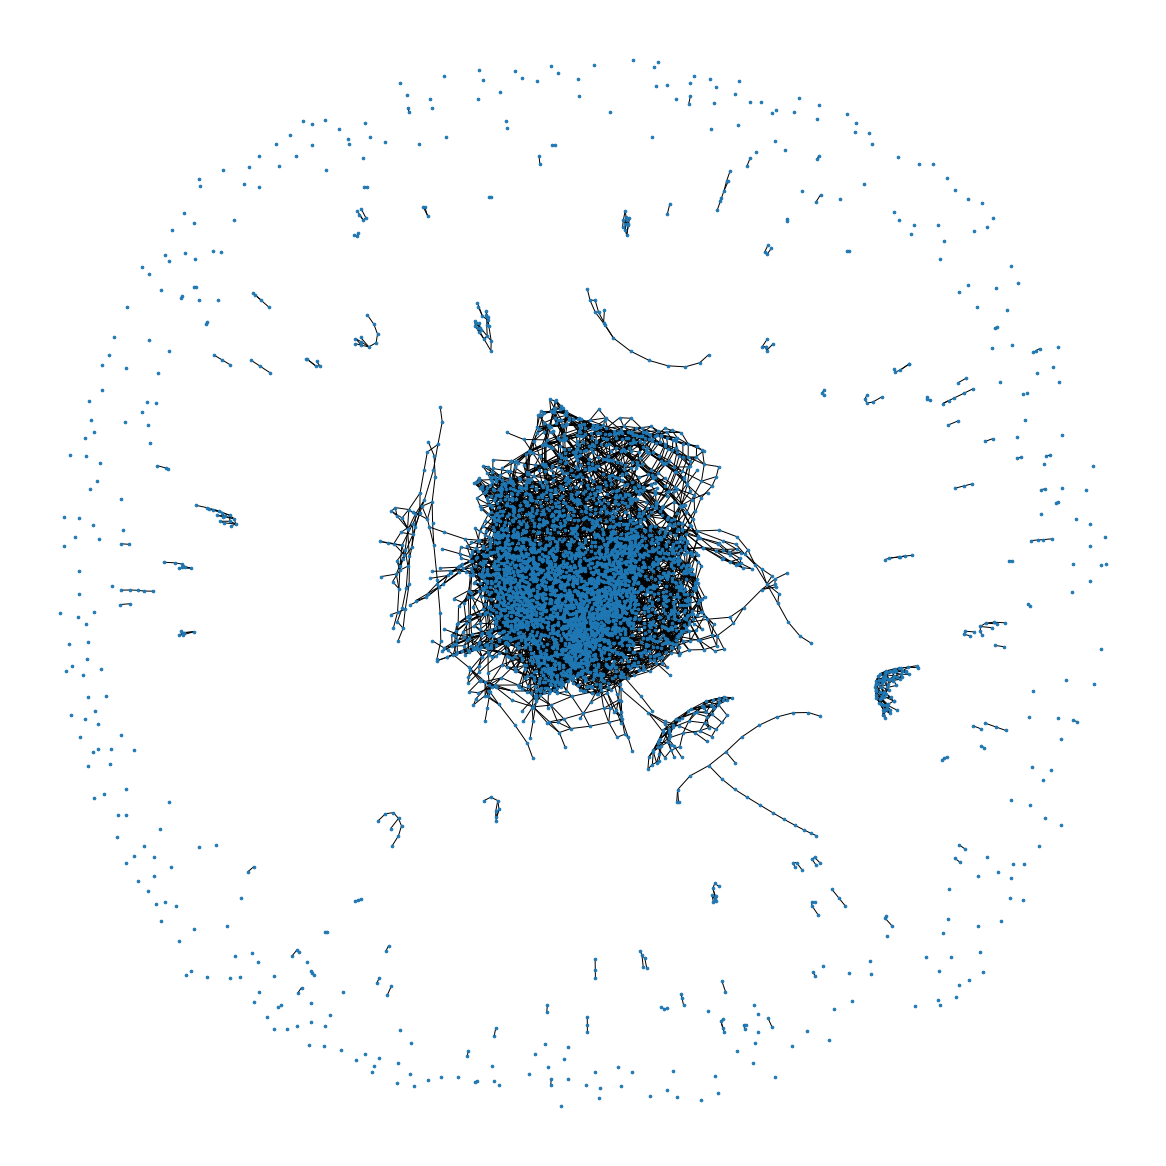

In [217]:
plt.figure(figsize=(16,16))
nx.draw(G, node_size=7)
plt.show()

In [40]:
#nx.degree(G)
#nx.info(G)
#nx.density(G)
#nx.is_directed(G)
#nx.degree_centrality(G)

In [42]:
nx.degree_histogram(G)

[418, 372, 333, 392, 537, 623, 599, 545, 807, 676, 90]

### Some tests made while developing new isotope checker

In [204]:
teste = formula_file2[formula_file2['NeutralMass'] < (3+1)*100]
teste = teste[teste['NeutralMass'] > 3*100]
teste['NeutralMass']
dict_iso={}
for j in range(len(teste)):
        mass = teste.iloc[j,0]
        tup = form_checker(mass, threshppm, formulas['dict' + str(3*100)], teste.iloc[j,-1], teste, dict_iso = dict_iso) 
        dict_iso = tup[-1]

300.08511646688 301.08847130187996
Empty DataFrame
Columns: [NeutralMass, C, H, O, N, S, P, Na, C13, CAN1 (1)]
Index: []
            Abundance   C   H  O  N  S  P  Cl  F  Valency  C13 Abun  \
300.084823   0.880160   8  13  3  8  0  1   0  0     True  0.078877   
300.085007   0.787341  16  17  0  2  1  1   0  0     True  0.141118   
300.085203   0.855122   6  16  6  6  1  0   0  0     True  0.057475   
300.085387   0.764943  14  20  3  0  2  0   0  0     True  0.119966   

              C13 mass  C13 check  
300.084823  301.088178      False  
300.085007  301.088362      False  
300.085203  301.088558      False  
300.085387  301.088742      False  
300.26730646688 301.27066130187995
Empty DataFrame
Columns: [NeutralMass, C, H, O, N, S, P, Na, C13, CAN1 (1)]
Index: []
Empty DataFrame
Columns: [Abundance, C, H, O, N, S, P, Cl, F, Valency, C13 Abun, C13 mass, C13 check]
Index: []
302.04346646688 303.04682130187996
Empty DataFrame
Columns: [NeutralMass, C, H, O, N, S, P, Na, C13, CAN1 (1)]

386.13119646687994 387.1345513018799
Empty DataFrame
Columns: [NeutralMass, C, H, O, N, S, P, Na, C13, CAN1 (1)]
Index: []
            Abundance   C   H  O   N  S  P  Cl  F  Valency  C13 Abun  \
386.131182   0.820218  13  14  3  12  0  0   0  0     True  0.119446   
386.131302   0.787695  20  24  2   2  0  2   0  0     True  0.176477   
386.131366   0.733720  21  18  0   6  1  0   0  0     True  0.172603   
386.131499   0.855506  10  23  8   6  0  1   0  0     True  0.095835   

              C13 mass  C13 check  
386.131182  387.134537      False  
386.131302  387.134657      False  
386.131366  387.134721      False  
386.131499  387.134854      False  
386.63282646688 387.63618130187996
Empty DataFrame
Columns: [NeutralMass, C, H, O, N, S, P, Na, C13, CAN1 (1)]
Index: []
Empty DataFrame
Columns: [Abundance, C, H, O, N, S, P, Cl, F, Valency, C13 Abun, C13 mass, C13 check]
Index: []
390.13185646688 391.13521130187996
Empty DataFrame
Columns: [NeutralMass, C, H, O, N, S, P, Na, C13, CA

In [238]:
for i in [558.48588646688, 559.2816064668799]:
    tup = form_checker(i, threshppm, formulas['dict' + str(5*100)], teste.iloc[j,-1], teste) 
tup

558.48588646688
558.48588646688
558.48588646688 559.4892413018799
559.2816064668799
559.2816064668799
559.2816064668799 560.2849613018799


(559.2816064668799, 'C27H45NO9S', 559.281503198, {})